In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline
matplotlib.rc('figure', figsize=(8, 6))
np.random.seed(2015)

# 1. Review of the Ising Model

- $N$ particles/molecules/magnetic dipoles with $\sigma = \pm 1$

- "Nearest neighbor" interaction Hamiltonian

$$ E=-J\sum_{ [i,j] }\sigma_i\sigma_j-H\sum_i\sigma_i \quad (1)$$

where $[i, j]$ denotes summation over nearest-neighbor pairs -- topology dependent!

### 1D Ising Model

No phase transition above 0K (Ising)

### 2D Ising Model (aka square-lattice Ising model) at $H=0$

Analytic solution by Onsager:

- Transition temperature: $$ T_C = \frac{1}{k_B}\frac{2J}{\ln(1+\sqrt{2})} \approx 2.269\frac{J}{k_B} \quad (2)$$

- Spontaneous magnization: $$ |\bar{\sigma}| = \Big\{
    \begin{array}
    ((1 - \sinh^{-4}(\frac{2J}{k_B T}))^{1/8} & (T < T_C) \\
    0 & (T \geq T_C)
    \end{array} \quad (3)
    $$

- Due to its simplicity and interesting analytic behavior, the 2D Ising Model is frequently used as a "testing stone" for Molecular Dynamics/Monte Carlo algorithms

- We will only consider the case of $H=0$ in this notebook

# 2. Monte Carlo Simulation

## 2.1 Importance sampling

- The total number of microstates, $\Omega$, approaches astronomical magnitudes even for a small system with $N \sim 10^4$

- However, when $N$ is sufficiently large most of the microstates have extremely low probability compared to those in the vincinity of the most probable states.

- Metropolis (pioneer of the MC methods):
> ...instead of choosing configurations randomly, then weighting them with $\exp(-E/k_BT)$, we choose configurations with a probability $\exp(-E/k_BT)$ and weight them evenly.[1]

- This is called **importance sampling**.

### How samples are gathered:

- **Molecular dynamics simulation (MD)**: start from first principles and simulate the time evolution of the system. For thermodynamic systems at equilibrium, points along any phase trajectories should be a good representation of the ensemble (ergodicity)

- **Monte Carlo simulation (MC)**: Carry out a hypothetical "random walk" on the phase space, in effect creating a **Markov Chain**. Since the term *Monte Carlo* is used ubiquitously to represent anything that involve some degrees of uncertainty, these methods are sometimes differentiated from others by the name **Markov chain Monte Carlo (MCMC)**

The most widely used MC sampling algorithm is the **Metropolis-Hastings algorithm**.

## 2.2 The Metropolis-Hastings Algorithm

### Markov Chain 101

- A markov chain consists of discrete states (labeled from 1 through $\Omega$). The state of the systme at time step $n$ is denoted $x_{n}$

- The chain evolves according to the rule 

$$ Pr[x_{n+1}=j|x_n=i] = t_{ij} \quad (i,j=1,2,\ldots,\Omega) \quad (4)$$ 

The $t_{ij}$ are called **transition probabilities** and $T=(t_{ij})$ is the **transition matrix**.

- **Stationary distribution $\{\pi_i\}$**:

$$ \pi_j = \sum_{i=1}^{\Omega}t_{ij}\pi_i(j = 1, 2, \ldots, \Omega) \quad (5)$$

It can be proven that a markov chain converges to a unique stationary distribution if the **ergodicity condition** is satiesfied (this notion of "ergodicity" is different from that used in statistical mechanics). Ergodicity is assumed throughout our discussions (for a detailed discussion see [2]).

- **Detailed balance**: For all $i$ and $j$, $t_{ij}\pi_i = t_{ji}\pi_j$. Intuitively, this means there's no net "probability flow" between any two states. It's easy to see that a system under detailed balance must also be in a stationary distribution.

### The M-H algorithm generates its samples by constructing a chain in detailed balance

To sample the probability distribution $\pi(n) \, (n = 1,2,\ldots,\Omega)$, the algorithm goes as follows. Suppose the system is currently in state $a$:

- **Propose** a state $b$ different from $a$ using a predefined *a priori* distribution $A(a \rightarrow b)$ (More on this later).

- Carry out a Bernoulli trial with probability 

$$ p(a \rightarrow b) := \min[1,\frac{\pi(b)}{\pi(a)}\frac{A(b \rightarrow a)}{A(a \rightarrow b)}] \quad (6)$$

**Accept** state $b$ if the trial succeeds (this means updating the system to state $b$ as well as recording $b$ to the list of samples). Else, **reject** it and stays in $a$ (also recording $a$ in the list of samples).

Check for yourself that the system defined above is in fact a markov chain with transition probability $t(a \rightarrow b) = A(a \rightarrow b)p(a \rightarrow b)$. Its stationary distribution is no other than $\pi(n)$. In addition, detailed balance is satiesfied upon reaching equilibrium.

Note that in (6) only the quotient between $\pi(b)$ and $\pi(a)$ are required for the algorithm to work. This means we can specify $\pi(n)$ within an uncertainty of a multiplicative constant. In the case of statistical mechanics, we can ditch the partition function $Z$ altogether and only compute the Boltzman factor $\exp(-E(a)/k_BT)$ of the various states.

## 2.3 Example: a Metropolis-Hastings dice

- Consider a loaded dice. Upon throwing, the results have the following distribution: $\pi(1)=1/2$，$\pi(2)=1/4$，$\pi(3)=1/8$，$\pi(4)=1/16$，$\pi(5)=\pi(6)=1/32$
- Choose a unifrom *a priori* distribution: $A(i \rightarrow j) = 1/6$

In [2]:
def dice_samples(trials):
    prob = {1: 1/2, 2: 1/4, 3: 1/8, 4: 1/16, 5: 1/32, 6: 1/32}
    samples = np.zeros(trials + 1, dtype=int)
    samples[0] = 1
    for i in range(trials):
        a = samples[i]
        b = np.random.random_integers(1, 6) # uniform a priori distribution
        pa = prob[a]
        pb = prob[b]
        if pb >= pa or np.random.rand() < pb / pa:
            samples[i + 1] = b
        else:
            samples[i + 1] = a
    return samples

def summarize(samples):
    '''
    Return the percentage of every face in the samples
    '''
    num_samples = len(samples)
    distribution = {i: (samples == i).sum() * 100 / num_samples for i in [1, 2, 3, 4, 5 ,6]} # 百分数
    return distribution

We change the number of MC steps to give a view to the time evolution of the M-H chain:

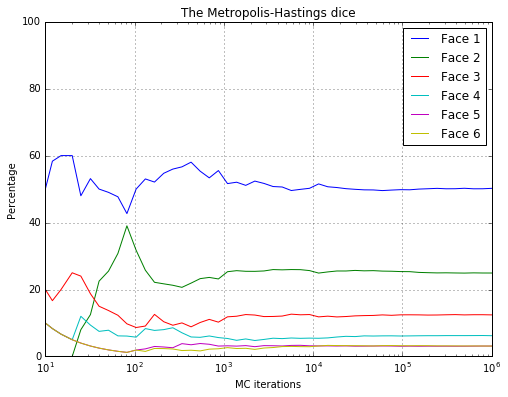

In [3]:
samples = dice_samples(1000000)
ns = np.array(np.logspace(1, 6, num=50), dtype=int)

distributions = {i: np.zeros(50) for i in [1, 2, 3, 4 ,5 ,6]}
for index in range(50):
    n = ns[index]
    distribution = summarize(samples[:n])
    for i in [1, 2, 3, 4, 5, 6]:
        distributions[i][index] = distribution[i]
for i in [1, 2, 3, 4, 5, 6]:
    plt.plot(ns, distributions[i], label='Face {}'.format(i))
plt.xlabel('MC iterations')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.semilogx()
plt.legend()
plt.grid()
plt.title("The Metropolis-Hastings dice")

So the constructed chains do converto our desired value. But notice the length of transient steps: it took as much as 10000 steps for us to obtain a reasonably accurate value! As we will see below, this "high accuracy, low precision" characteristic of MC methods (a slow convergence to an exact value) is ubiquitous. It remains a problem til this day to find a MC method that have fast convergence.

# 3. MC Simulation of the Ising Model

## 3.1 The "single-flip" MC

### A uniform representation for both the 1D and 2D Ising Model

The modern language of nearest-neighbor interation topology is graph theory. We use the most popular graph storage format --- the **adjacency list** format --- to record the structure of 1D (chain) and 2D (square lattice) Ising Models:

In [4]:
# First, we need helper function to transform between the (i, j) coordinate of a 2D lattice and a serial one
# a: length of the square lattice's side
def flatten_2d(i, j, a):
    return i * a + j # serial No. = row No. * lenght + colum No.
def unflatten_2d(n, a):
    j = n % a
    i = (n - j) // a
    return i, j

# Generate the adjacency list
def gen_neighbors_1d(N):
    neighbors = np.zeros((N, 2), dtype=int)
    for n in range(N):
        neighbors[n][0] = (n - 1) % N # left
        neighbors[n][1] = (n + 1) % N # right
    return neighbors

def gen_neighbors_2d(a):
    neighbors = np.zeros((a*a, 4), dtype=int)
    for n in range(a*a):
        i, j = unflatten_2d(n, a)
        neighbors[n][0] = flatten_2d(i, (j - 1) % a, a) # left
        neighbors[n][1] = flatten_2d(i, (j + 1) % a, a) # right
        neighbors[n][2] = flatten_2d((i - 1) % a, j, a) # up
        neighbors[n][3] = flatten_2d((i + 1) % a, j, a) # down
    return neighbors

Let $J=1$，$k_B=1$ in the following discussion:

- State of the markov chain = microstate of the Ising Model $\vec{\sigma} := (\sigma_1\ldots\sigma_N)^T$

- *A priori* probability: choose uniformly from any state that relates to the current state by **a single spin flip**

- Energy difference resulting from a single flip: $\delta E= 2\sigma_i\sum_{[i,j]}\sigma_j $

- Acceptance probability $ P=\min(1, \exp(-\delta E/T)) $

- The "single flip" mechanism makes the previously defined adjacency list particularly useful.

In [5]:
def MH_single_flip(neighbors_list, T, iterations):
    '''
    This function performs single flip MC iterations for an Ising system with arbitrary topology, 
    given by the adjaceny list `neighbors_list`.
    The inital state is chosen randomly.
    
    Returns
    =======
    `magnetization`: magnetization (average molecular spin) at each MC step
    `energy`: total energy of the system at each MC step
    '''
    # Initialization
    size = neighbors_list.shape[0]
    spins = np.random.random_integers(0, 1, size)
    spins[spins == 0] = -1
    # Allocation
    magnetization = np.zeros(iterations + 1)
    energy = np.zeros(iterations + 1)
    magnetization[0] = spins.sum()
    energy[0] = -spins.dot(spins[neighbors_list].sum(axis=1)) / 2
    
    for step in range(iterations):
        n = np.random.randint(0, size) # Choose next state according to the a priori distribution
        delta_E = 2 * spins[n] * spins[neighbors_list[n]].sum()
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
            # Acceptance
            spins[n] = -spins[n]
            magnetization[step + 1] = magnetization[step] + 2 * spins[n]
            energy[step + 1] = energy[step] + delta_E
        else:
            # Rejection
            magnetization[step + 1] = magnetization[step]
            energy[step + 1] = energy[step]
    return magnetization / size, energy

Let's see the result for 1D and 2D Ising Models:

In [6]:
def plot_magnetization(dimension):
    if dimension == 1:
        neighbors_list = gen_neighbors_1d(400)
    elif dimension == 2:
        neighbors_list = gen_neighbors_2d(20)
    T_list = [0.5, 1.0, 1.5, 1.8, 2.0, 2.2, 2.4, 3.0, 3.5]
    fig = plt.figure(figsize=(12, 40))
    for i in range(9):
        T = T_list[i]
        magnetization, _ = MH_single_flip(neighbors_list, T, 100000)
        # Random walk history
        fig.add_subplot(9, 2, 2 * i + 1)
        plt.plot(magnetization)
        plt.ylim(-1, 1)
        plt.ylabel('Magnetization')
        plt.xlabel('Iterations')
        plt.annotate('T = {}'.format(T), (10000,0.8))
        plt.grid()
        # Sample distribution histogram
        fig.add_subplot(9, 2, 2 * i + 2)
        plt.hist(magnetization, bins=np.linspace(-1, 1, num=20), orientation='horizontal')
        plt.ylim(-1, 1)
        plt.xlabel('Counts')
        plt.grid()
    plt.suptitle("Monte Carlo simulation history & distribution to the {:d}D Ising Model".format(dimension))

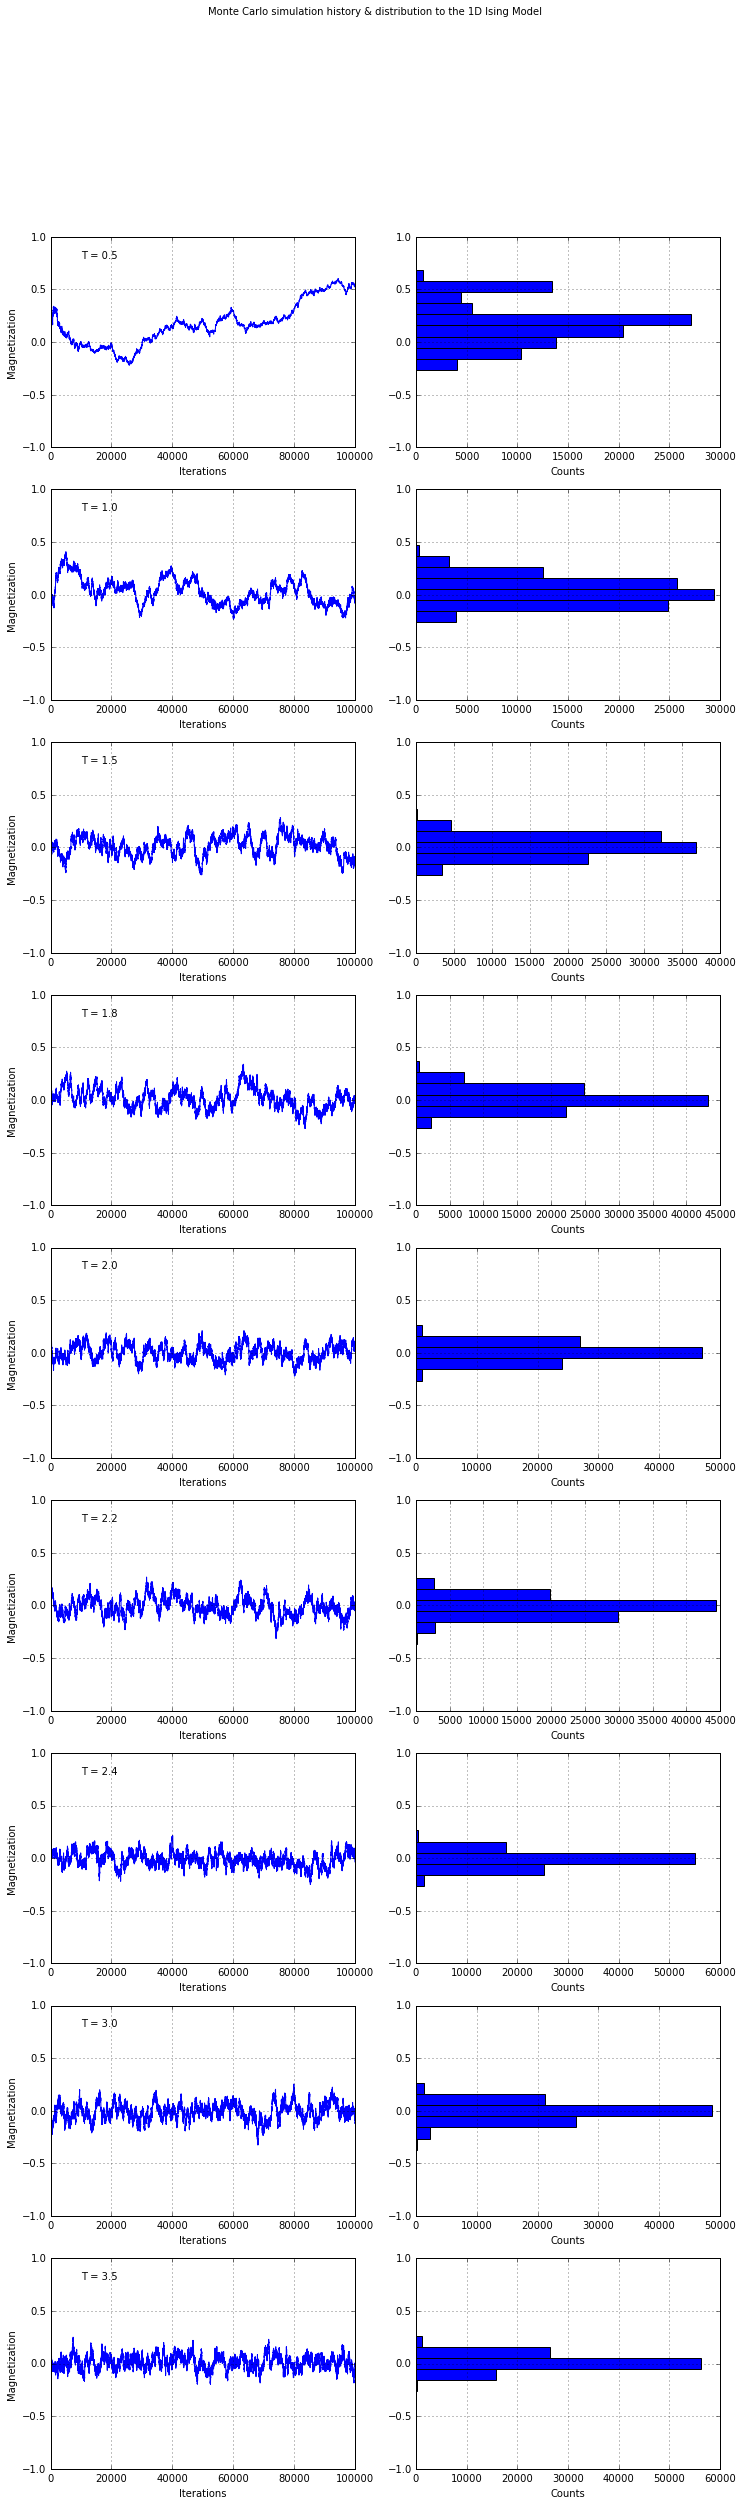

In [7]:
plot_magnetization(1)

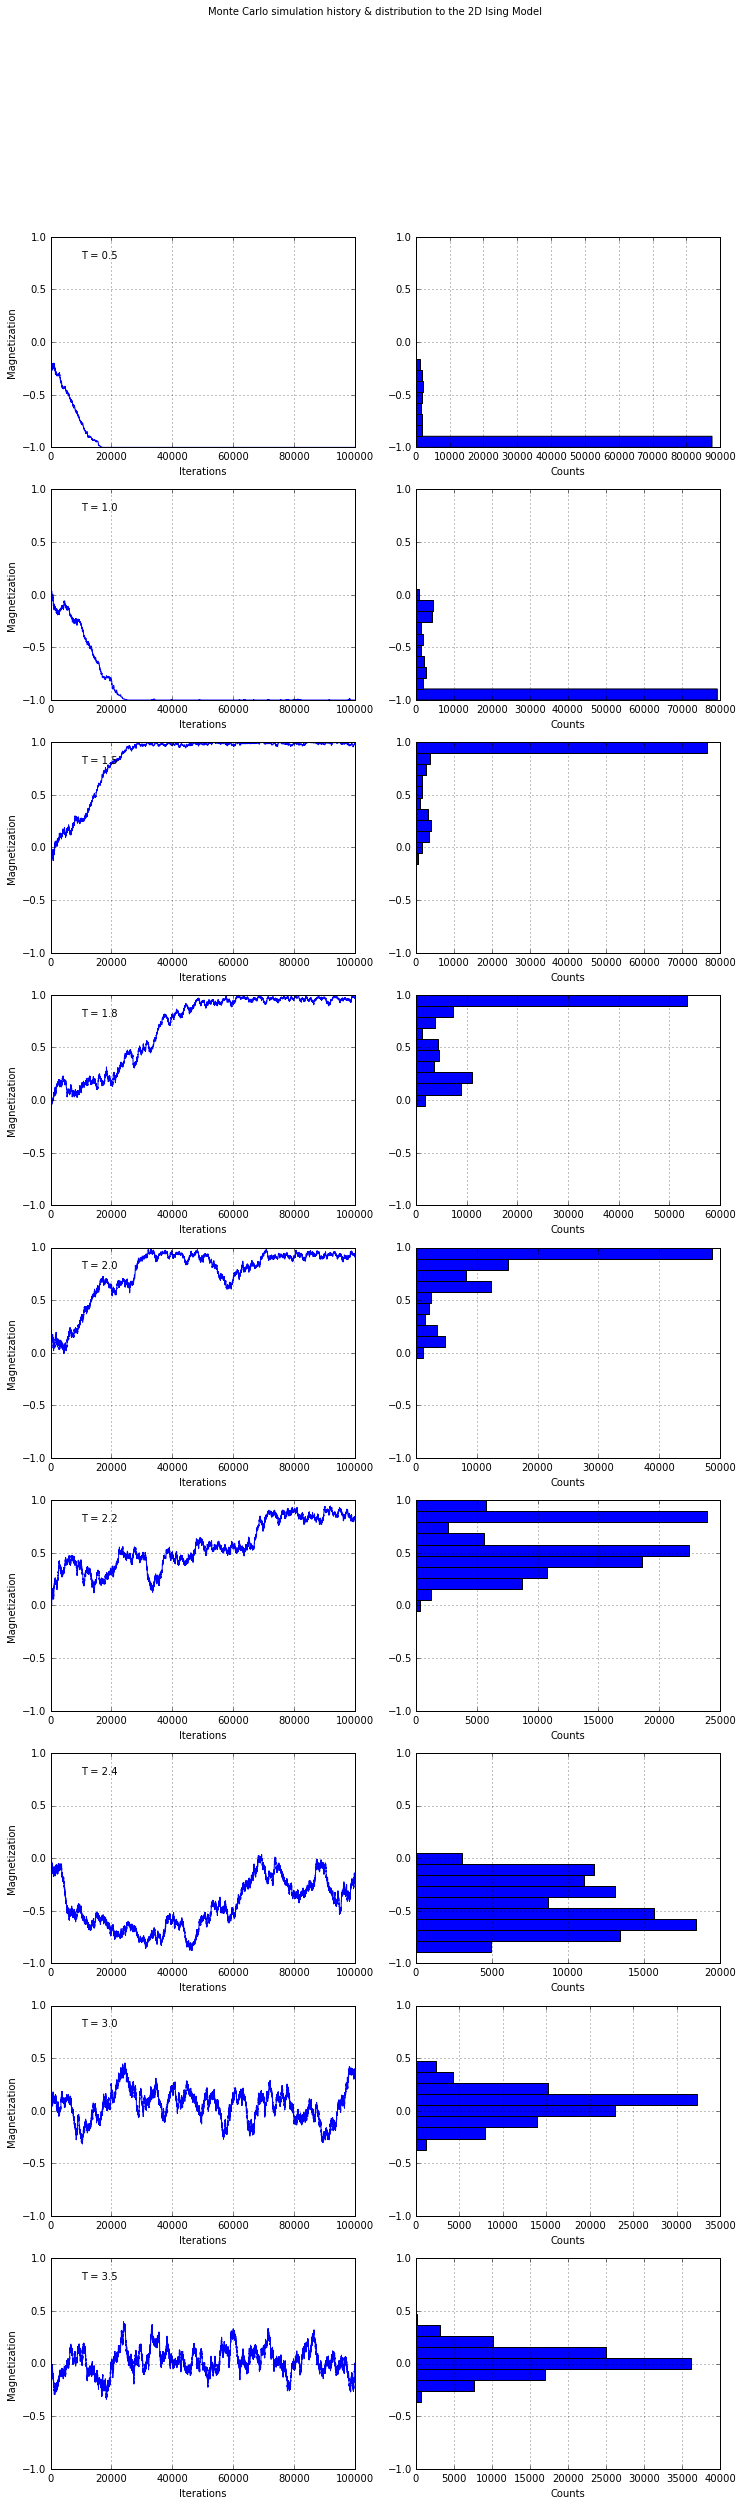

In [8]:
plot_magnetization(2)

Remarks:

- No spontaneous Magnetization is seen in the 1D case, in agreement with the result from Ising.

- The 2D case displays spontaneous behavior roughly for $T$ smaller than the theoretical critical temperature $T_C$. However, instead of a two-peak distribution as prescribed by the canocical distribution, only one peak is observed.

- Convergence of the markow chain is very slow for $T \approx T_C$. We can prove theoretically that the number of steps required actually diverges as $T \rightarrow T_C$. This is called the **critical slowing down** behavior.

Interesting results! But why?

## 3.2 Theoretical interlude: the clustering of spins near $T_C$

Recall the definition of the spin correlation function:

$$ g(x, y) := E[\sigma(m + x, n + y)\sigma(m, n)] - E[\sigma(m + x, m + y)]E[\sigma(m, n)] \quad (7)$$

where the expectation is taken for all grid points $(m, n)$. The above formula can be simplified if we assume periodic boundary consitions for all sides:

$$ g(x, y) = E[\sigma(m + x, n + y)\sigma(m, n)] - M^2 \quad (8) $$

where $M := E[\sigma(n)]$. The spin correlation function can tell us more about what happens when $T \approx T_C$.

In [9]:
def spin_correlation(spins, a):
    M = spins.mean()
    spins_2d = spins.reshape((a, a))
    rs = np.arange(-a/2, a/2 + 1, dtype=int)
    num_rs = len(rs)
    correlations = np.zeros((num_rs, num_rs))
    for i, y in enumerate(rs):
        for j, x in enumerate(rs):
            correlations[i, j] = (spins_2d * np.roll(np.roll(spins_2d, x, axis=1), y, axis=0)).mean() + M**2
    return correlations

We modify the single-flip MC code a bit to have it output snapshots of the system at the given time stamps:

In [10]:
def gen_snapshots(time_stamps, a, T):
    iterations = time_stamps[-1]
    snapshots = {}
    
    neighbors_list = gen_neighbors_2d(a)
    size = neighbors_list.shape[0]
    spins = np.random.random_integers(0, 1, size)
    spins[spins == 0] = -1
    for step in range(iterations):
        n = np.random.randint(0, size)
        delta_E = 2 * spins[n] * spins[neighbors_list[n]].sum()
        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / T):
            spins[n] = -spins[n]
        if step + 1 in time_stamps:
            snapshots[step + 1] = {
                'spins': spins.copy().reshape((a, a)), 
                'magnetization': spins.mean(),
                'correlation': spin_correlation(spins, a)
            }
    return snapshots

This is what happens when $T = 2.2$:

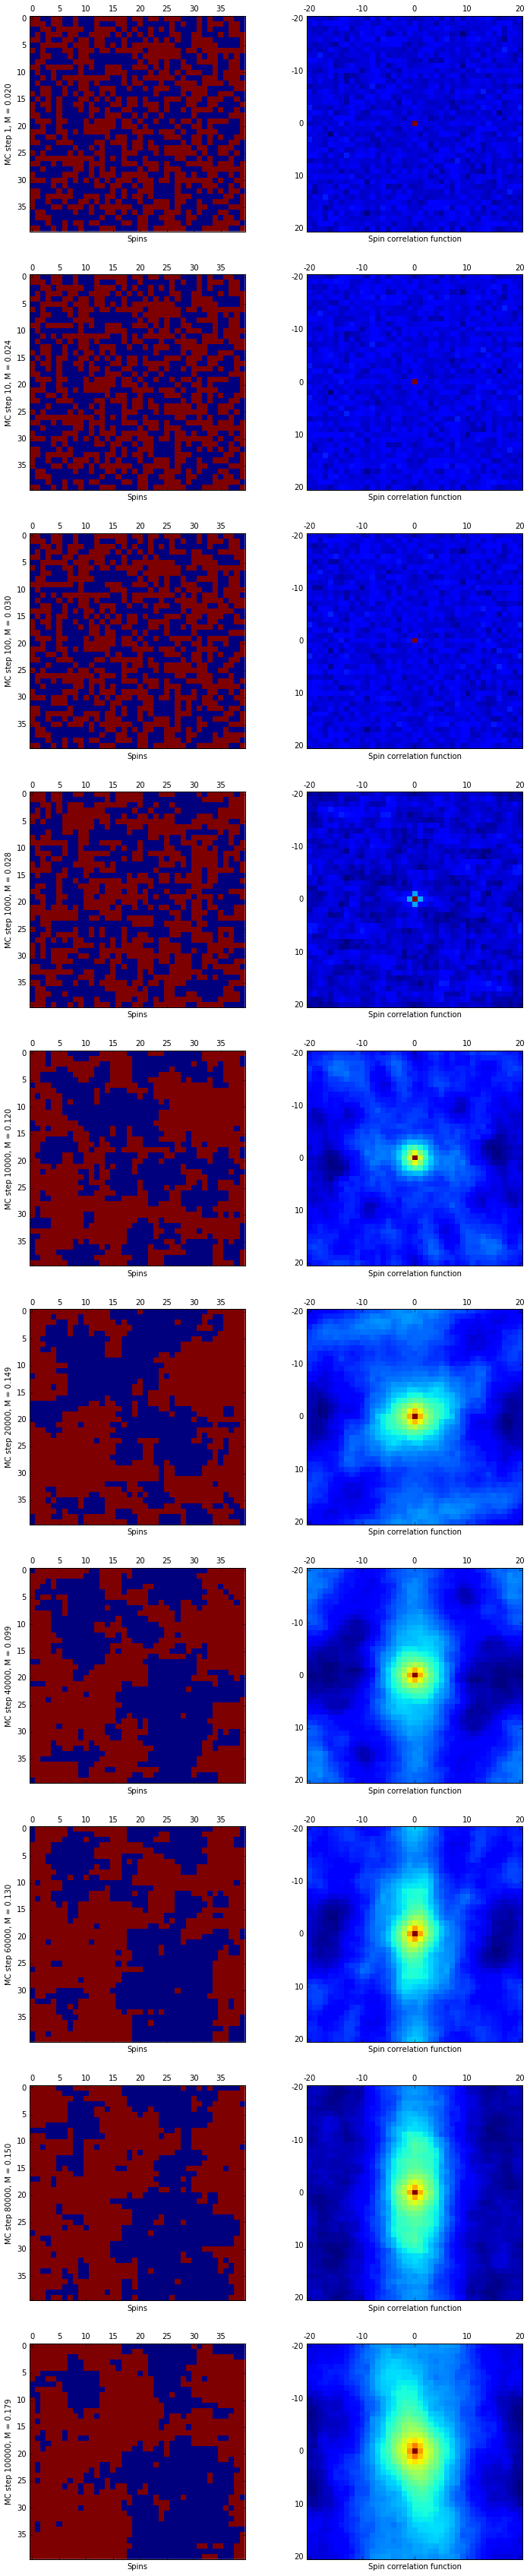

In [11]:
a = 40
T = 2.2
time_stamps = np.array([1, 10, 100, 1000, 10000, 20000, 40000, 60000, 80000, 100000])
snapshots = gen_snapshots(time_stamps, a, T)
fig, axes = plt.subplots(10, 2, figsize=(12, 6 * 10))
for i, t in enumerate(time_stamps):
    axes[i][0].matshow(snapshots[t]['spins'], interpolation='none')
    axes[i][0].set_ylabel('MC step {}, M = {:.3f}'.format(t, snapshots[t]['magnetization']))
    axes[i][0].set_xlabel('Spins')
    axes[i][1].matshow(snapshots[t]['correlation'])
    axes[i][1].set_xlabel('Spin correlation function')
    axes[i][1].set_xticks([0, 10, 20, 30, 40])
    axes[i][1].set_xticklabels([-20, -10, 0, 10, 20])
    axes[i][1].set_yticks([0, 10, 20, 30, 40])
    axes[i][1].set_yticklabels([-20, -10, 0, 10, 20])

So the markov chain, instead of converging, actually goes into an ordered stated with considerable correlation between the spins. The spin clusters formed in the process makes it more difficult for future states to be accepted, as a randomly picked molecule is more like to be inside a cluster than at the boundary between two clusters. Flipping this molecule would thus increase the system's energy, so it's more likely to be rejected. This is the explanation for the above mentioned critical slowing down behavior.

The same argument can be applied to the spontaneous magnitization state for $T \ll T_C$. In this case, once the system enter the ordered state the giant cluster makes further flipping very difficult to accept. Because we have arbitrarily constrained the system to move only a small step in configuration space per MC step, it would take forever for it to move from one steady state to another.

## 3.3 Cluster MC

To address the problems mentioned above, the **cluster Monte Carlo** method is proposed to allow for large configuration space hopping between two MC steps.

Specifically:

- A "seed" is chosen randomly at the start of each MC step.

- A breadth-first search is performed in the lattice starting from the "seed". Whenever a molecule with the same spin as the seed is encountered, it is added to the breadth-first queue with probability p. The search is carried on until the queue is exhausted, generating a cluster of same-spin molecules from the breadth-first tree.

- A new state is proposed by flipping all molecules within the cluster. The acceptance/rejection procedure is identical to that given by Metropolis-Hastings.

To carry out cluster MC, we need to calculated the effective *a priori* distribution from the procedures described above. We state the result without proving (refer to Ref [2] for a complete discussion):

If we set $p$ to the "magic number" $1-e^{2/T}$, then $p(a \rightarrow b) \equiv 1$, which means the next state will always be accepted. We can already see that under this choice MC iterations can be carried out way quicker than the single-flip scheme.

In [12]:
def cluster_MC(neighbors_list, T, iterations):
    p = 1 - np.exp(-2 / T) # "magic number"
    # Initialization
    size = neighbors_list.shape[0]
    spins = np.random.random_integers(0, 1, size)
    spins[spins == 0] = -1
    # Allocation
    magnetization = np.zeros(iterations + 1)
    magnetization[0] = spins.sum()
    energy = np.zeros(iterations + 1)
    energy[0] = -spins.dot(spins[neighbors_list].sum(axis=1))
    
    for step in range(iterations):
        # Use a deque to implement breadth-first search
        n0 = np.random.randint(0, size)
        sign = spins[n0]
        cluster = set([n0])
        pockets = deque([n0])
        finished = False
        while not finished:
            try:
                n = pockets.popleft()
                neighbors = neighbors_list[n]
                for neighbor in neighbors:
                    if spins[neighbor] == sign and neighbor not in cluster and np.random.rand() < p:
                        cluster.add(neighbor)
                        pockets.append(neighbor)
            except IndexError:
                finished = True
        # Flip the cluster
        cluster = np.fromiter(cluster, dtype=int)
        spins[cluster] = -sign
        magnetization[step + 1] = magnetization[step] - 2 * sign * len(cluster)
        energy[step + 1] = -spins.dot(spins[neighbors_list].sum(axis=1))
    return magnetization / size, energy / 2 # Every pair is counted two times

Cluster MC vs. single-flip MC in the field:

In [13]:
def plot_magnetization_cluster(dimension):
    if dimension == 1:
        neighbors_list = gen_neighbors_1d(400)
    elif dimension == 2:
        neighbors_list = gen_neighbors_2d(20)
    T_list = [0.5, 1.0, 1.5, 1.8, 2.0, 2.2, 2.4, 3.0, 3.5]
    fig = plt.figure(figsize=(12, 40))
    for i in range(9):
        T = T_list[i]
        magnetization, _ = cluster_MC(neighbors_list, T, 1000)
        # 随机行走历史
        fig.add_subplot(9, 2, 2 * i + 1)
        plt.plot(magnetization)
        plt.ylim(-1, 1)
        plt.ylabel('Magnetization')
        plt.xlabel('Iterations')
        plt.annotate('T = {}'.format(T), (50,0.8))
        # 样本分布直方图
        fig.add_subplot(9, 2, 2 * i + 2)
        plt.hist(magnetization, bins=np.linspace(-1, 1, num=20), orientation='horizontal')
        plt.ylim(-1, 1)
        plt.xlabel('Counts')
    plt.suptitle("Monte Carlo simulation history & distribution to the {:d}D Ising Model".format(dimension))

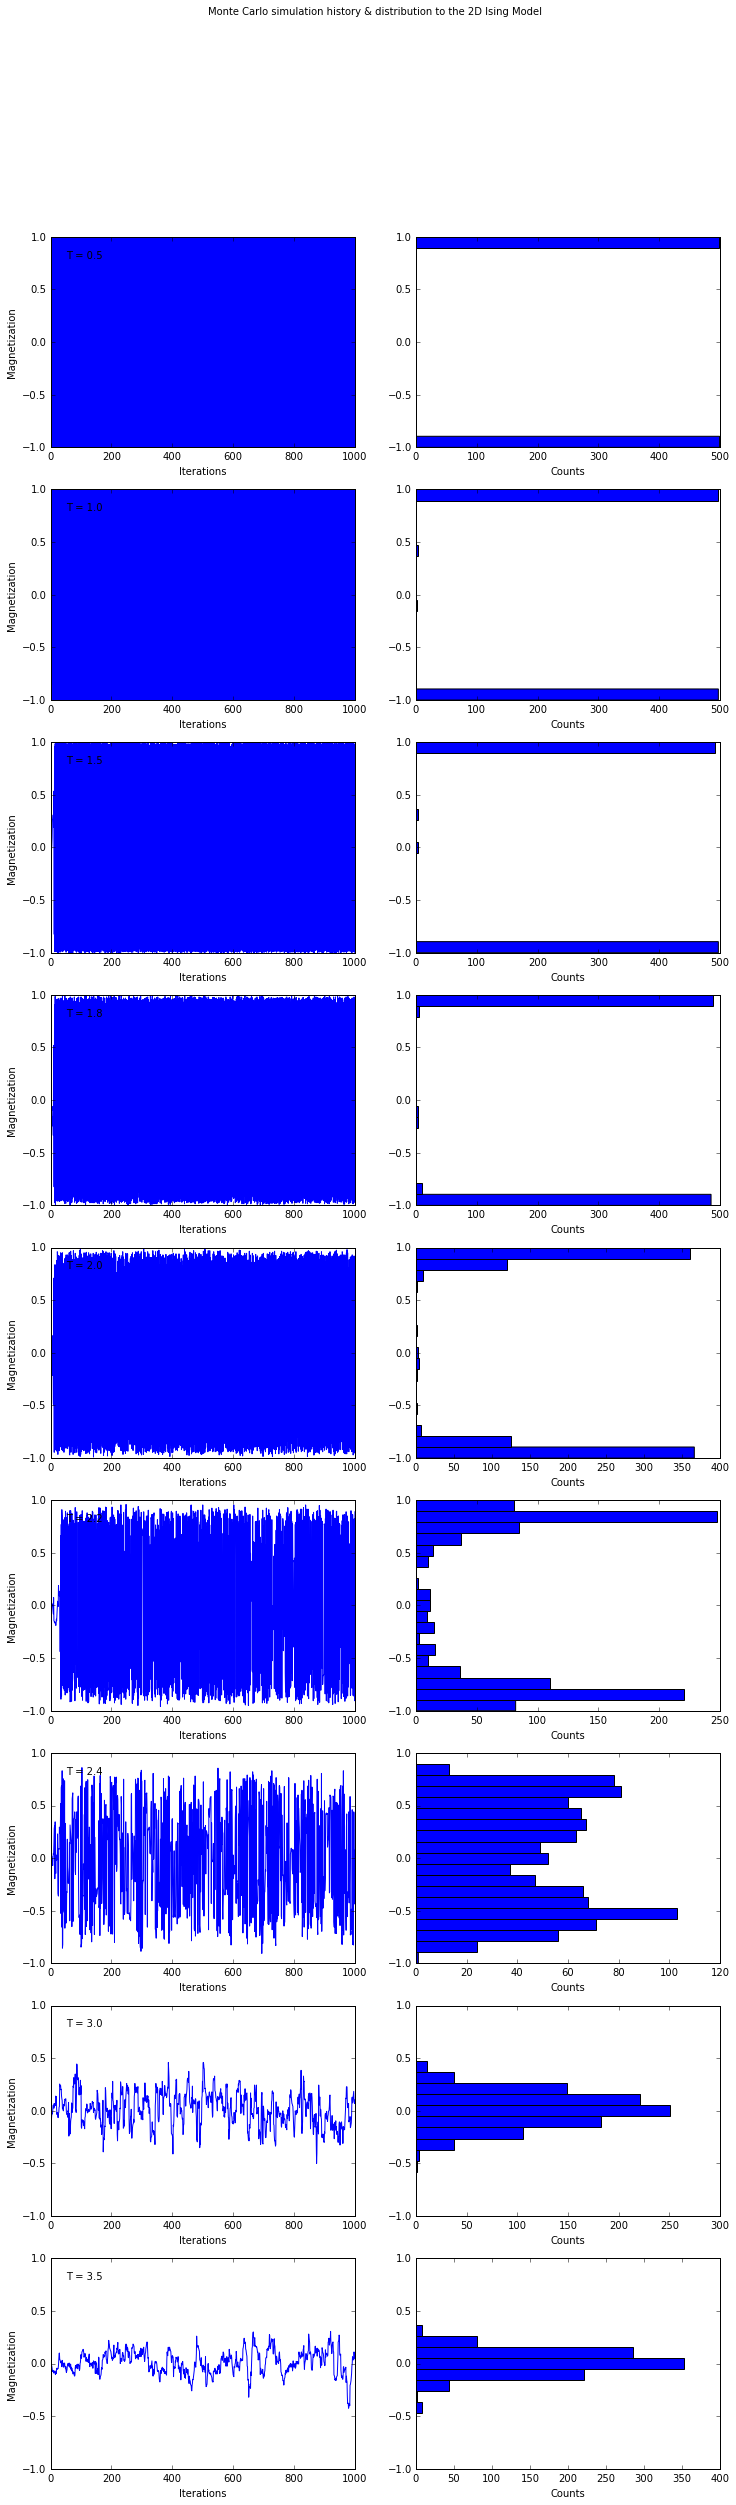

In [14]:
plot_magnetization_cluster(2)

## 3.4 Comparison to theoretical results

We compare results from cluster MC to the ones given by Onsager in (3):

In [15]:
def averages(magnetization, energy, T):
    '''计算各量的系综平均'''
    M = np.abs(magnetization).mean()
    E = energy.mean()
    CV = energy.var() / T
    return M, E, CV

In [16]:
# The code below runs VERY SLOWLY
points = 31
dimension = 64
iterations = 5000

neighbors_list = gen_neighbors_2d(dimension)
Ts = np.linspace(1.0, 4.0, points)
Ms = np.zeros(points)
for i in range(points):
    T = Ts[i]
    magnetization, _ = cluster_MC(neighbors_list, T, iterations)
    Ms[i] = np.abs(magnetization).mean()
#     print("Iteration for T = {:.3f} complete".format(T)) # Uncomment to print progress as the simulation goes

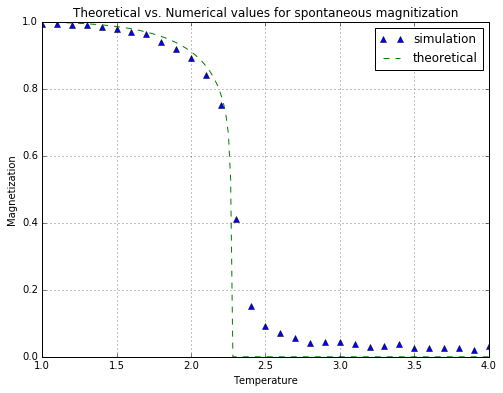

In [17]:
Onsager_Tc = 2.269
Ts_plot = np.linspace(1.0, 4.0, num=200)
Onsager_Ms = np.zeros(len(Ts_plot))
for i, T in enumerate(Ts_plot):
    if T <= 2.269:
        Onsager_Ms[i] = (1 - (np.sinh(2/T))**(-4))**(1/8)
plt.plot(Ts, Ms, '^', label='simulation')
plt.plot(Ts_plot, Onsager_Ms, '--', label='theoretical')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.grid()
plt.title("Theoretical vs. Numerical values for spontaneous magnitization")

# 4. Development of MC methods

- Different choice of *a priori* distributions;

- Hybrid MC/MD simulations;

- Better sample generation: correlation, buring and thinning;

- MCMC applied to Hierarchichal Bayesian Models in the field of statistics. An excellent material is [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb)

# References

[1] N.Metropolis, A.W.Rosenbluth, M.N.Rosenbluth, A.H.Teller, E.Teller, *Equation of State Calculations by Fast Computing Machines*, The Journal of Chemial Physics 21(1953), pp.1087

[2] K.Werner, *Statistical Mechanics: Algorithms and Computations*, Oxford(2006)

In [18]:
import sys
print("Python version = ", sys.version)
print("Numpy version = ", np.version.version)
print("Matplotlib version = ", matplotlib.__version__)

Python version =  3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Numpy version =  1.10.4
Matplotlib version =  1.5.1
